In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline
)
from peft import LoraConfig
from trl import SFTTrainer
# from peft import PeftModel

In [ ]:
def format_prompt(sample):
    return f"""
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{sample["instruction"]}

### Input:
{sample["input"]}

### Response:
{sample["output"]}
"""

In [ ]:
# Dataset
training_data = load_dataset("json", data_files="new_dataset.json", split="train")

In [ ]:
# Model and tokenizer names
base_model_name = "NousResearch/Llama-2-7b-chat-hf"
refined_model = "test_model_simple" #You can give it your own name

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_tokenizer.padding_side = "right"  # Fix for fp16

# Quantization Config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False
)

# Model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quant_config,
    device_map={"": 0}
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

In [ ]:
# LoRA Config
peft_parameters = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    task_type="CAUSAL_LM"
)

# Training Params
train_params = TrainingArguments(
    output_dir=refined_model,
    num_train_epochs=20,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    disable_tqdm=False
)

# Trainer
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=training_data,
    peft_config=peft_parameters,
    tokenizer=llama_tokenizer,
    max_seq_length=1024,
    packing=True,
    formatting_func=format_prompt,
    args=train_params
)

# Training
fine_tuning.train()

# Save Model
fine_tuning.model.save_pretrained(refined_model)

In [1]:
import torch
torch.cuda.is_available()

True

In [4]:
!pip install transformers==4.31

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 526.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 3.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.0
    Uninstalling transformers-4.30.0:
      Successfully uninstalled transformers-4.30.0


In [2]:
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

# Load finetuned LLM model and tokenizer
model = AutoPeftModelForCausalLM.from_pretrained(
    'simple_model/checkpoint-60',
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained('simple_model/checkpoint-60')

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/repos/93/64/93644d087bcdd24640b29e7a3c92ff463e8f74a5bce00308b05b1b56faef7cc1/66dec18c9f1705b9387d62f8485f4e7d871ca388718786737ed3c72dbfaac9fb?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model-00001-of-00002.safetensors%3B+filename%3D%22model-00001-of-00002.safetensors%22%3B&Expires=1709796359&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwOTc5NjM1OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy85My82NC85MzY0NGQwODdiY2RkMjQ2NDBiMjllN2EzYzkyZmY0NjNlOGY3NGE1YmNlMDAzMDhiMDViMWI1NmZhZWY3Y2MxLzY2ZGVjMThjOWYxNzA1YjkzODdkNjJmODQ4NWY0ZTdkODcxY2EzODg3MTg3ODY3MzdlZDNjNzJkYmZhYWM5ZmI%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=hzrm2Kff6NNCKP1uQUytd%7EUSxbg17iBQlghYVU2%7E9LL6nHUKQhyeXiiQmH0juCwlF9EL7fomomNHtpBFVGULxGGevinLbZG4n5K7IfW1hshw6mwGKv-04bUZMDc2zwc1tPF0l6T4eaOsl3vNzCAZoZ4dxxbqYnHSgPfc1ORHXgX2TzRNI4fi0Cfm1zonPtcnznwbobGVnMZVIUnl

model-00001-of-00002.safetensors:   9%|8         | 860M/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
dataset = load_dataset("json", data_files="new_dataset.json", split="train")
sample = dataset[randrange(len(dataset))]

prompt = f"""
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{sample["instruction"]}

### Input:
{"I am at the bed, bring me hot tea from oven"}

### Response:
"""

input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
outputs = model.generate(input_ids=input_ids, max_new_tokens=512, do_sample=True, top_p=0.6,temperature=0.9)

print(f"Instruction:\n{sample['instruction']}\n")
print(f"Input:\n{sample['input']}\n")
print(f"Generated Response:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}\n")
print(f"Ground Truth:\n{sample['output']}")

Generating train split: 0 examples [00:00, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/aliud/anaconda3/envs/LLM/lib/python3.11/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/home/aliud/anaconda3/envs/LLM/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


Instruction:
You should generate XML to perform actions using these tags: task, action, actionType, object, location. Coordinates of locations: table, bed, fridge, oven, door, window

Input:
Move a laptop from the table to the bed.

Generated Response:
<task><action><actionType>GO</actionType><location>oven</location></action><action><actionType>TAKE</actionType><object>hot tea</object><location>oven</location></action><action><actionType>GO</actionType><location>table</location></action><action><actionType>PUT</actionType><object>hot tea</object><location>table</location></action><action><actionType>GO</actionType><location>HOME</location></action></task>


Ground Truth:
<task><action><actionType>GO</actionType><location>table</location></action><action><actionType>TAKE</actionType><object>laptop</object><location>table</location></action><action><actionType>GO</actionType><location>bed</location></action><action><actionType>PUT</actionType><object>laptop</object><location>bed</locati

In [ ]:
prompt = f"""
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{sample["instruction"]}

### Input:
`i'm in the kitchen. Take chocolate from fridge and wash dishes.

### Response:
"""

input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
outputs = model.generate(input_ids=input_ids, max_new_tokens=512, do_sample=True, top_p=0.6,temperature=0.9)

print(f"Instruction:\n{sample['instruction']}\n")
print(f"Input:\n{sample['input']}\n")
print(f"Generated Response:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}\n")
print(f"Ground Truth:\n{sample['output']}")

In [ ]:
import xml.etree.ElementTree as ET
from datasets import load_dataset

In [ ]:
parse = load_dataset("json", data_files="dataset copy.json", split="train")

In [ ]:
print(ET.tostring(root, encoding='utf8').split()[-1].decode())

In [ ]:
new_dataset = []

In [ ]:
def to_sample(locations, obj):
    return f'<task><action><actionType>GO</actionType><location>{locations[0]}</location></action><action><actionType>TAKE</actionType><object>{obj}</object><location>{locations[0]}</location></action><action><actionType>GO</actionType><location>{locations[1]}</location></action><action><actionType>PUT</actionType><object>{obj}</object><location>{locations[1]}</location></action><action><actionType>GO</actionType><location>HOME</location></action></task>'

In [ ]:
for i in range(len(parse)):
    sample = {}
    sample['instruction'] = parse[i]['instruction']
    sample['input'] = parse[i]['input']
    tree = ET.ElementTree(ET.fromstring(parse[i]['output']))
    root = tree.getroot()
    locations = []
    obj = ''
    for j in range(len(root)):
        if root[j][0].text != 'GO':
            obj = root[j][1].text
            locations.append(root[j][2].text)
    sample['output'] = to_sample(locations, obj)
    new_dataset.append(sample)

In [ ]:
to_sample(locations, obj)

In [ ]:
new_dataset

In [ ]:
import json

In [ ]:
with open("new_dataset.json", "w") as outfile: 
    json.dump(new_dataset, outfile)

In [ ]:
load_dataset("json", data_files="new_dataset.json", split="train")

In [4]:
task = 'I am at the bed, bring me hot tea from oven'
f"""
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You should generate XML to perform actions using these tags: task, action, actionType, object, location. Coordinates of locations: table, bed, fridge, oven, door, window", "input": "Move a glass from the table to the fridge.

### Input:
{task}

### Response:
"""

input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
outputs = model.generate(input_ids=input_ids, max_new_tokens=512, do_sample=True, top_p=0.6,temperature=0.9)

print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):])

<task><action><actionType>GO</actionType><location>oven</location></action><action><actionType>TAKE</actionType><object>hot tea</object><location>oven</location></action><action><actionType>GO</actionType><location>table</location></action><action><actionType>PUT</actionType><object>hot tea</object><location>table</location></action><action><actionType>GO</actionType><location>HOME</location></action></task>



In [2]:
import xml.etree.ElementTree as ET
def parse_xml(bt):
    tree = ET.ElementTree(ET.fromstring(bt))
    root = tree.getroot()
    for child in root:
        print(child[0].text)

In [7]:
parse_xml('<task><action><actionType>GO</actionType><location>oven</location></action><action><actionType>TAKE</actionType><object>hot tea</object><location>oven</location></action><action><actionType>GO</actionType><location>table</location></action><action><actionType>PUT</actionType><object>hot tea</object><location>table</location></action><action><actionType>GO</actionType><location>HOME</location></action></task>')

GO
TAKE
GO
PUT
GO


In [27]:
import xml.etree.ElementTree as ET

input_string = '<task><action><actionType>GO</actionType><location>oven</location></action><action><actionType>TAKE</actionType><object>hot tea</object><location>oven</location></action><action><actionType>GO</actionType><location>table</location></action><action><actionType>PUT</actionType><object>hot tea</object><location>table</location></action><action><actionType>GO</actionType><location>HOME</location></action></task>'

# Parse the input string into an ElementTree
root = ET.fromstring(input_string)

# Function to recursively format the ElementTree with specific indentation
def format_element(element, level=0):
    indent = '    ' * level
    result = f'{indent}<{element.tag}>\n'

    for child in element:
        result += format_element(child, level + 1)

    if element.text and element.text.strip():
        result += f'{indent}    {element.text.strip()}\n'

    result += f'{indent}</{element.tag}>\n'
    return result

# Format the ElementTree with specific indentation
formatted_string = format_element(root)

# Display the collected string
print(formatted_string)


<task>
    <action>
        <actionType>
            GO
        </actionType>
        <location>
            oven
        </location>
    </action>
    <action>
        <actionType>
            TAKE
        </actionType>
        <object>
            hot tea
        </object>
        <location>
            oven
        </location>
    </action>
    <action>
        <actionType>
            GO
        </actionType>
        <location>
            table
        </location>
    </action>
    <action>
        <actionType>
            PUT
        </actionType>
        <object>
            hot tea
        </object>
        <location>
            table
        </location>
    </action>
    <action>
        <actionType>
            GO
        </actionType>
        <location>
            HOME
        </location>
    </action>
</task>



In [37]:
import xml.etree.ElementTree as ET

input_string = '<task><action><actionType>GO</actionType><location>oven</location></action><action><actionType>TAKE</actionType><object>hot tea</object><location>oven</location></action><action><actionType>GO</actionType><location>table</location></action><action><actionType>PUT</actionType><object>hot tea</object><location>table</location></action><action><actionType>GO</actionType><location>HOME</location></action></task>'

# Parse the input string into an ElementTree
root = ET.fromstring(input_string)

# Function to recursively format the ElementTree with opening tag and text on the same line
def format_element(element, level=0):
    indent = '    ' * level
    if element.text is not None and element.text.strip():
        result = f'{indent}<{element.tag}>{element.text.strip()}'
    else:
        result = f'{indent}<{element.tag}>\n'

    for child in element:
        result += format_element(child, level + 1)

    result += f'{indent}</{element.tag}>\n'
    return result

# Format the ElementTree with opening tag and text on the same line
formatted_string = format_element(root)

# Display the collected string
print(formatted_string)


<task>
    <action>
        <actionType>GO        </actionType>
        <location>oven        </location>
    </action>
    <action>
        <actionType>TAKE        </actionType>
        <object>hot tea        </object>
        <location>oven        </location>
    </action>
    <action>
        <actionType>GO        </actionType>
        <location>table        </location>
    </action>
    <action>
        <actionType>PUT        </actionType>
        <object>hot tea        </object>
        <location>table        </location>
    </action>
    <action>
        <actionType>GO        </actionType>
        <location>HOME        </location>
    </action>
</task>



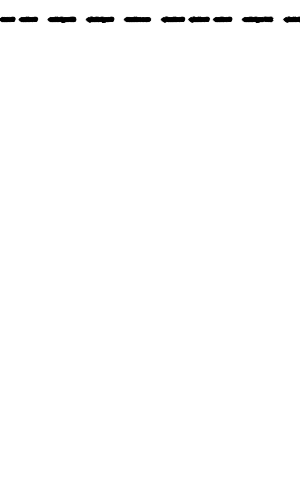

In [39]:
import cv2 
import numpy as np
from PIL import Image
    
# Reading an image in default mode 
image = np.ones((500, 300), dtype = np.uint8) * 255
    
# Window name in which image is displayed 
window_name = 'Image'
  
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
  
# org 
org = (0, 20) 
  
# fontScale 
fontScale = 0.1
   
# Blue color in BGR 
color = (0) 
  
# Line thickness of 2 px 
thickness = 2
   
# Using cv2.putText() method 
image = cv2.putText(image, formatted_string, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 

Image.fromarray(image)
   

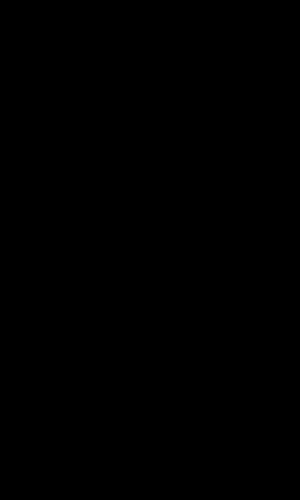

In [23]:
Image.fromarray(np.zeros((500, 300), dtype = np.uint8))